# Bitcoin Financial Modelling
##Based of previous experimentation, I'm going to break down what I've found into classes, and explain each one individually

In [281]:
import numpy as np
import os
import pickle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas.io.data as web
%matplotlib inline

###Step 1: Setting up our dataset

In [282]:
# This class is responsible for holding our initial pandas dataframe after we import our data from a pickled object in a file
class Dataset():
    def __init__(self, loc):
        # load from file
        mydata = None
        try:
            mydata = pickle.load(open('./{}'.format(loc), 'rb'))
        except:
            mydata = pickle.load(open('../resources/{}'.format(loc), 'rb'))
        
        # Create the dataframe and label the columns
        self.dataset = pd.DataFrame(mydata, columns=["Time", "Value"]).drop_duplicates()
        
        # Set time as the index column. 
        # pd.to_datetime just makes the the time column pandas time dataype (easier to manipulate)
        self.dataset["Time"] = pd.to_datetime(self.dataset["Time"])
        self.dataset = self.dataset.set_index('Time')
        
        # Set our market change... this tells us how many percent the market has moved from the last sample datapoint.
        self.dataset['Market'] = np.log(self.dataset['Value']/ self.dataset['Value'].shift(1))

##Step 2: A class to create strategies
### Each Strategy represents 3 things
- A short term average x
- A long term average y
- A deviation boundary d
the buy signal is given when d > (x-y)
the sell signal is given when d < (x-y)

This way when we start unexpectedly rising, we buy, and ride the wave.
When we start sinking, we get out quick.

In [283]:
class Strategy():
    # Take name and a dataset
    def __init__(self, dataset, name, stop=False):
        self.name = name
        # We only care about market and regime values
        # We need to call convert convert_objects so things don't go tits up
        self.dataset = pd.DataFrame(dataset[['Market','Regime','Strategy']])#.convert_objects(convert_numeric=True)
        # Calculate the strategies taking if we don't count shorting (useful for final profit margins)

    def get_hourly_gain(self):
        new_ds = pd.DataFrame(self.dataset)
        new_ds['gain'] = self.dataset['Strategy'].cumsum().apply(np.exp) - self.dataset['Strategy'].shift(60).cumsum().apply(np.exp)
        return new_ds
    def get_gain(self, gain):
        new_ds = pd.DataFrame(self.dataset)
        new_ds['gain'] = self.dataset['Strategy'].cumsum().apply(np.exp) - self.dataset['Strategy'].shift(gain).cumsum().apply(np.exp)
        return new_ds
    # These are our different inits effectively.
    # from regime is from an existing dataset with a regime already worked out
    @classmethod
    def from_regime(cls, dataset, name):
        new_dataset = pd.DataFrame(dataset[['Market','Regime']]).convert_objects(convert_numeric=True)
        new_dataset['Strategy'] = np.where(new_dataset['Regime'].shift(1) > 0, new_dataset['Regime'].shift(1) * new_dataset['Market'], 0)
        new_dataset = new_dataset.convert_objects(convert_numeric=True)
        return Strategy(new_dataset, name)
    
    # Return our strategy created from a couple of means and their standard deviations.
    @classmethod
    def from_means(cls, dataset, means, deviation):
        mean1 = means[0]
        mean2 = means[1]
        # Give it a name that makes sense
        name = "{}-{}-{}".format(str(mean1),str(mean2),str(deviation))
        # See if the means are already in the main dataset... this is just to save on computation time.
        cols = list(dataset.columns.values)
        # If these means haven't mean figured out yet, then do it
        if mean1 not in cols:
            dataset[mean1] = np.round(pd.rolling_mean(dataset['Value'], window=mean1), 2)
        if mean2 not in cols:
            dataset[mean2] = np.round(pd.rolling_mean(dataset['Value'], window=mean2), 2)
        
        # Next lets create a new dataset to stop us from cluttering the old one
        new_dataset = pd.DataFrame(dataset[['Market',mean1,mean2]])
        # Work out the difference between the means
        new_dataset['Difference']= dataset[mean1] - dataset[mean2]
        
        # Work out what our buy/sell regime would be with these means and this standard deviation
        new_dataset['Regime'] = np.where(new_dataset['Difference'] > deviation, 1, 0)
        new_dataset['Regime'] = np.where(new_dataset['Difference'] < -deviation, -1, new_dataset['Regime'])
        # Caltulate strategies if shorting is included, good for determining performance
        # Work out hourly gain, I need to make this more general
        new_dataset['Strategy'] = new_dataset['Regime'].shift(1) * new_dataset['Market']
        return Strategy(new_dataset, name)

###Step 3: Next let's create a class to work out which strategy is performing best

In [284]:
class Winners():
    def __init__(self, strategies, market_series, max_mean, gain_val = 60):
        # We just set this so that we know how much data to ignore at the start of our dataset..
        # (due to incomplete means)
        self.max_mean = max_mean
        # Make our panel (pandas 3D dataset)
        items = {s.name:s.get_gain(gain_val) for s in strategies}
        pan = pd.Panel(items)
        
        # Compare the gains of each strategy
        gains = pan.transpose(2,0,1)['gain'].transpose().dropna()
        
        # Create our dataset on the "Regime" field, because really, the buy/sell is all we care about
        self.dataset = pan.transpose(2,0,1)['Regime'].transpose().dropna()
        
        # Use the market data from the imported dataset
        self.dataset['Market'] = market_series
        
        # Work out our winner for each moment in time
        self.dataset['Winner'] = gains.idxmax(axis=1).dropna()
        # Drop any lines with null in
        self.dataset = self.dataset[self.dataset['Winner'].notnull()]
        
    
    def get_regime(self, minutes_val):
        # Cut anything that might have been calculated on incomplete mean values
        winners = pd.DataFrame(self.dataset.ix[self.max_mean:])
        
        # Resample (after working out which is the winner, use this for the next n minutes)
        # After some experimentation, it's fairly clear, this should be as small as possible... so 1 
        winners['resample'] = winners['Winner'].asfreq(pd.DateOffset(minutes=minutes_val))
        winners['resample']=winners['resample'].fillna(method='pad')
        
        # Default regime is hold (0)
        winners['Regime'] = 0
        
        # For each of our strategies, check if it has winners, and map the strategies regime to the overall regime
        column_list = winners.columns.values.tolist()
        for group in column_list:
            winners["Regime"] = np.where(winners['resample'] == group,winners[group],winners["Regime"])
            
        # Return a copy of our winner dataframe
        return pd.DataFrame(winners)
    
    

###Step 4: Let's actually use these things and get some input data

We'll create our means, the difference between them representing our deviation buy/sell trigger
You'll find that different means can cause wildly different amounts of variation in results.
It's worth playing with this a bit.

In [306]:
means = range(5, 60 , 5)
sds = np.arange(0.1,1.1,0.2)
dataset = Dataset('stats_pickle5')
strategies = [Strategy.from_means(dataset.dataset, mean_tup, sd) for mean_tup in list(itertools.combinations(means, 2)) for sd in sds]

# The Chart
## We can see here that our strategy is pretty good... this took some calibration though. 
###Try messing with the gain and update values to see how much the results vary

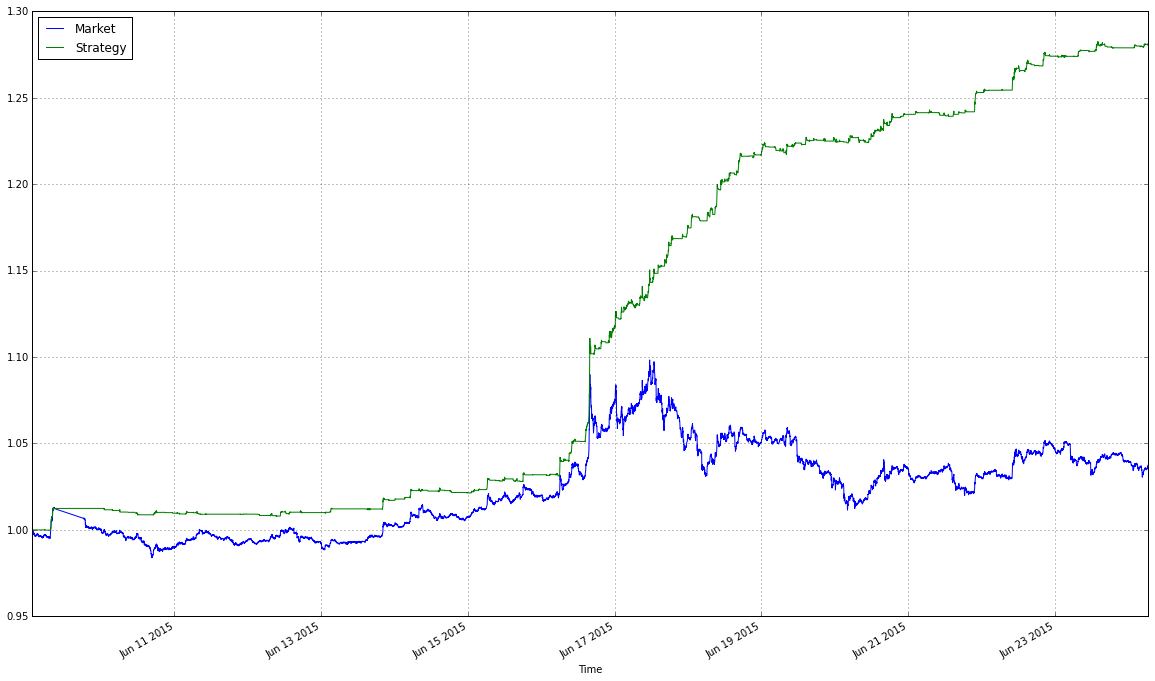

In [307]:
gain = 5
update = 1
w = Winners(strategies, pd.Series(dataset.dataset['Market']),means[-1],gain_val=gain)
Strategy.from_regime(w.get_regime(update),"Winning Regime").dataset[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))